In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import os
import DataLoad
import ImagePreprocessor
import Labeling
import TrajectoryPhy
import umap

amplif = 2

2023-01-12 22:27:22.823710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
all_data_path = './data/1_WT-H2BHalo_noIR/whole cells/Concatenation_20220217_20220301_20220601_H2B_Halo_before_entire_Cell'

print(f'Loading the data...')
all_histones = DataLoad.read_files(path=all_data_path, cutoff=10, chunk=False)
all_histones_label = Labeling.make_label(all_histones, radius=0.45, density=0.4)

n_immo=0
n_hybrid=0
n_mobile=0

for histone in all_histones:
    if all_histones_label[histone] == 0:
        n_immo += 1
    if all_histones_label[histone] == 1:
        n_hybrid += 1
    if all_histones_label[histone] == 2:
        n_mobile += 1
print(f'N_immo:{n_immo},  N_hybrid:{n_hybrid},  N_mobile:{n_mobile} ')

Loading the data...
N_immo:15843,  N_hybrid:2722,  N_mobile:817 


In [3]:
def make_training_sample(histones, histones_label):
    n_samples = 800
    immobile_histones = []
    hybrid_histones = []
    mobile_histones = []
    
    for histone in histones:
        if histones_label[histone] == 0:
            immobile_histones.append(histone)
        elif histones_label[histone] == 1:
            hybrid_histones.append(histone)
        else:
            mobile_histones.append(histone)
    immobile_histones = np.array(immobile_histones)
    hybrid_histones = np.array(hybrid_histones)
    mobile_histones = np.array(mobile_histones)
    
    immobile_histones = immobile_histones[np.random.choice(len(immobile_histones), n_samples, replace=False)]
    hybrid_histones = hybrid_histones[np.random.choice(len(hybrid_histones), n_samples, replace=False)]
    mobile_histones = mobile_histones[np.random.choice(len(mobile_histones), n_samples, replace=False)]

    return immobile_histones, hybrid_histones, mobile_histones

In [4]:
def write_training_sample(histones, histones_label):
    immobile_samples, hybrid_samples, mobile_samples = make_training_sample(histones, histones_label)
    with open('./training_sample_no_ir.rpt_tracked.trxyt', 'w') as file:
        for sample in immobile_samples:
            trajectories = histones[sample]
            for x, y, time in trajectories:
                trajec_num = sample.strip().split('.')[0]
                i_string = f'{trajec_num : <25}\t{x : <10}\t{y : <10}\t{time : <4}\n'
                file.write(i_string)
        for sample in hybrid_samples:
            trajectories = histones[sample]
            for x, y, time in trajectories:
                trajec_num = sample.strip().split('.')[0]
                i_string = f'{trajec_num : <25}\t{x : <10}\t{y : <10}\t{time : <4}\n'
                file.write(i_string)
        for sample in mobile_samples:
            trajectories = histones[sample]
            for x, y, time in trajectories:
                trajec_num = sample.strip().split('.')[0]
                i_string = f'{trajec_num : <25}\t{x : <10}\t{y : <10}\t{time : <4}\n'
                file.write(i_string)
        file.close()

In [5]:
write_training_sample(all_histones, all_histones_label)

In [2]:
data_path = './data/TrainingData'

print(f'Loading the data...')
histones = DataLoad.read_files(path=data_path, cutoff=10, chunk=False)
histones_label, histone_max_dist = Labeling.make_label(histones, radius=0.45, density=0.4)

n_immo=0
n_hybrid=0
n_mobile=0

for histone in histones:
    if histones_label[histone] == 0:
        n_immo += 1
    if histones_label[histone] == 1:
        n_hybrid += 1
    if histones_label[histone] == 2:
        n_mobile += 1
print(f'N_immo:{n_immo},  N_hybrid:{n_hybrid},  N_mobile:{n_mobile} ')

Loading the data...
N_immo:800,  N_hybrid:800,  N_mobile:800 


In [4]:
print(f'Image processing...')
histones_channel, nChannel = ImagePreprocessor.make_channel(histones, immobile_cutoff=0.3, hybrid_cutoff=10)
histones_imgs, img_size, time_scale = \
    ImagePreprocessor.preprocessing(histones, histones_channel, img_size=10, amplif=amplif, channel=nChannel)
print(f'Making imgs...')
zoomed_imgs, to_size = ImagePreprocessor.zoom(histones_imgs, size=img_size, to_size=(500, 500))

Image processing...
Making imgs...


In [6]:
reshaped_label = []
reshaped_imgs = []
for histone in zoomed_imgs:
    reshaped_imgs.append(zoomed_imgs[histone].reshape(-1))
    reshaped_label.append(histones_label[histone])
reshaped_imgs = np.array(reshaped_imgs)
print(reshaped_imgs.shape)

(2100, 750000)


In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(reshaped_imgs)
print(f'Data reducing end')

(2100, 2)


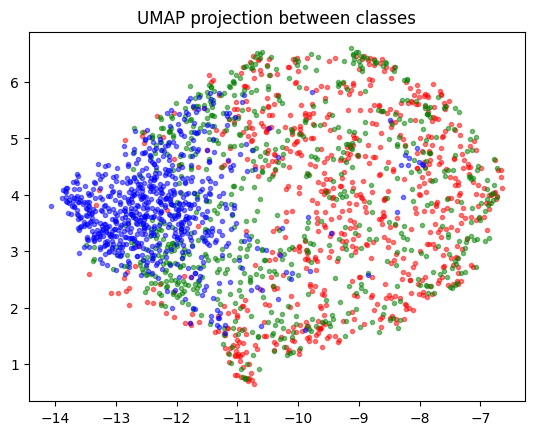

In [17]:
print(embedding.shape)  
color_vec = []
for i in range(len(reshaped_label)):
    if reshaped_label[i] == 0:
        color_vec.append('red')
    elif reshaped_label[i] == 1:
        color_vec.append('green')
    else:
        color_vec.append('blue')
        
fig, ax = plt.subplots()
for p in range(reshaped_imgs.shape[0]):
    ax.scatter(
        embedding[p][0],
        embedding[p][1],
        color=color_vec[p],
        alpha=0.5,
        s=9
    )
plt.title(f'UMAP projection between classes', fontsize=12)
plt.savefig(f'img/training_imgs/1.png')

Image processing...
Making imgs...


KeyboardInterrupt: 

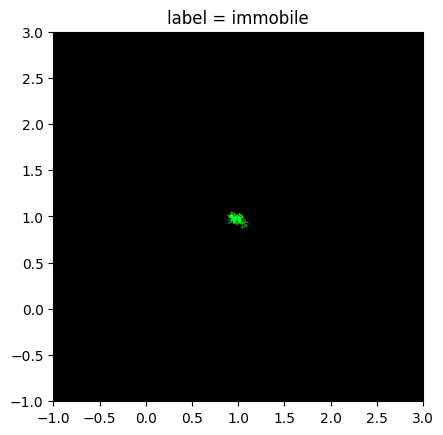

In [9]:
print(f'Image processing...')
histones_channel, nChannel = ImagePreprocessor.make_channel(histones, immobile_cutoff=0.3, hybrid_cutoff=10)
histones_imgs, img_size, time_scale = \
    ImagePreprocessor.preprocessing(histones, histones_channel, img_size=10, amplif=amplif, channel=nChannel)
print(f'Making imgs...')
zoomed_imgs, to_size = ImagePreprocessor.zoom(histones_imgs, size=img_size, to_size=(500, 500))

for i, histone in enumerate(histones):
    histone_first_pos = [int(histones[histone][0][0] * (10 ** amplif)),
                        int(histones[histone][0][1] * (10 ** amplif))]
    channels = histones_channel[histone]
    if histones_label[histone] == 0:
        if i%10 == 10:
            print(f'i={i}')
        ImagePreprocessor.img_save(zoomed_imgs[histone], histone, to_size, label=histones_label[histone],
                                histone_first_pos=histone_first_pos, amplif=amplif, path='img/training_imgs/')

In [ ]:
"""
histones_imgs, img_size, time_scale = img_preprocess.preprocessing3D(histones, img_size=8, amplif=2, channel=False, time_scale=600)
histone_names = np.array(list(histones.keys()))

xs_l = []
ys_l = []
zs_l = []

xs=[]
ys=[]
zs=[]
for i, histone in enumerate(histone_names[:30]):
    print(f'i = {i}')
    for x in range(800):
        for y in range(800):
            for z in range(600):
                if histones_imgs[histone][x][y][z] == 1:
                    xs.append(x)
                    ys.append(y)
                    zs.append(z)
    xs_l.append(xs)
    ys_l.append(ys)
    zs_l.append(zs)

%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(len(xs_l)):
    ax.scatter(xs_l[i], ys_l[i], zs_l[i])

ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Time')
plt.savefig('./sample3D.png')
"""

In [ ]:
"""
fig, axs = plt.subplots(2, 1, figsize=(15,15))
i = 0
ax_num = 0
for histone in histone_velocity:
    axs[ax_num].plot(accumulate(histone_velocity[histone]), alpha=0.5, label=str(histone))
    axs[ax_num].legend()
    i += 1
    if i%200 == 0:
        ax_num += 1
    if i==10:
        break

plt.savefig('img/velocity_2.png')
"""

"""
fig, axs = plt.subplots(10, 1, figsize=(15,15))
i = 0
ax_num = 0
for histone in histone_acc:
    axs[ax_num].plot(histone_acc[histone], alpha=0.5, label='A')
    i += 1
    if i%50 == 0:
        ax_num += 1
    if i==500:
        break

plt.savefig('img/acc.png')
"""

"""
fig, axs = plt.subplots(1, 1, figsize=(15,15))
for histone in distances:
    axs.scatter(distances[histone][0] / displacements[histone][0], displacements[histone][1])
    #axs.set_xlim(0, 4)
    #axs.set_ylim(0, 2.5)
plt.savefig('img/mobile_by_fraction.png')
"""

"""
for histone in distances:
    if distances[histone][0] / displacements[histone][0] > 1000:
        print(histone, distances[histone][0] , displacements[histone][0])
        preprocessing(histones[histone], 1)
"""

In [2]:
def read_report(path, amplif):
    with open(path, encoding="utf-8") as f:
        input = f.read()
    lines = input.strip().split('\n')
    ratio = lines[0].strip().split('\n')
    print(ratio)
    classified_histones = []
    for line in lines[1:]:
        info = line.strip().split('\t')
        color = int(info[-4].strip())
        xpos = round(float(info[-2].strip()), amplif)
        ypos = round(float(info[-1].strip()), amplif)
        classified_histones.append(np.array([xpos, ypos, color]))
    return np.array(classified_histones)

In [11]:
def cell_class_map(classified_histones, show):
    plt.figure()
    ax = plt.axes()
    ax.set_facecolor("black")
    #plt.xlim(0,25)
    #plt.ylim(0,25)
    for histone in classified_histones:
        if histone[2] in show:
            if histone[2] == 0:
                c = 'red'
            if histone[2] == 1:
                c = 'yellow'
            if histone[2] == 2:
                c = 'blue'
            plt.scatter(histone[0], histone[1], c=c, s=0.5, alpha=1)


['Immobile:0.8081841432225064, Hybrid:0.13964194373401534, Mobile:0.05217391304347826']


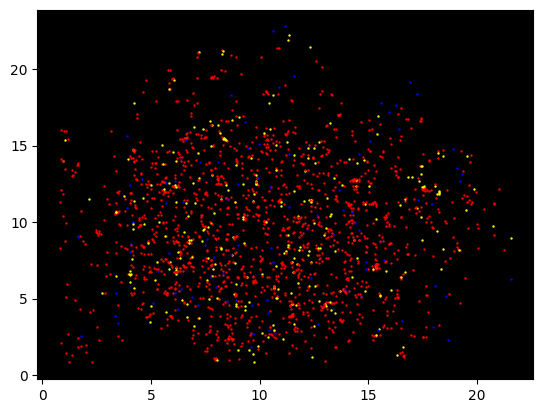

In [12]:
report_path = './result/report_testsample.csv'
classified_histones = read_report(report_path, amplif=2)
cell_class_map(classified_histones, [0,1,2])

['Immobile:0.8782098312545855, Hybrid:0.09537784299339692, Mobile:0.02641232575201761']


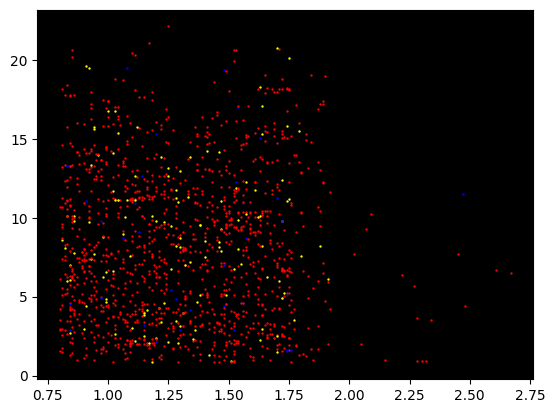

In [13]:
report_path = './result/report_allcrop.csv'
classified_histones = read_report(report_path, amplif=2)
cell_class_map(classified_histones, [0,1,2])

['Immobile:0.7689608915488597, Hybrid:0.17015787844391703, Mobile:0.060881230007223196']


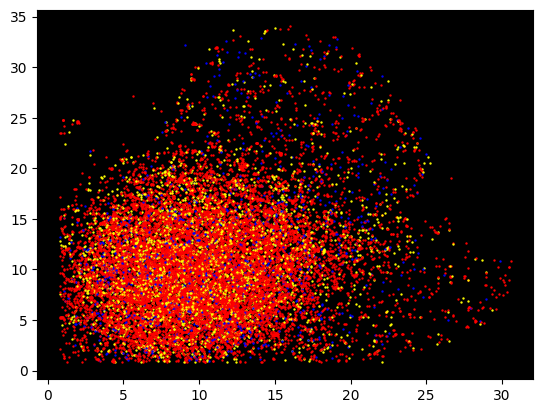

In [14]:
report_path = './result/report_allcell.csv'
classified_histones = read_report(report_path, amplif=2)
cell_class_map(classified_histones, [0,1,2])

['Immobile:0.7853682170542635, Hybrid:0.13565891472868216, Mobile:0.07897286821705427']


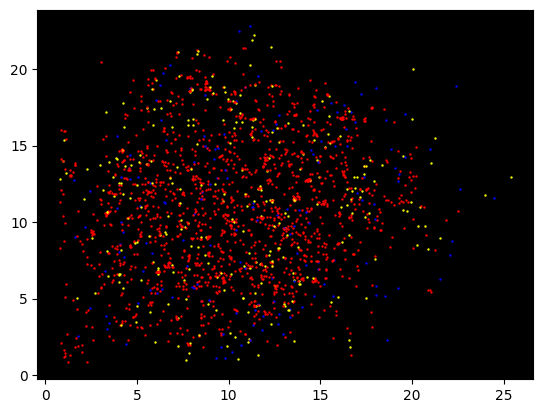

In [15]:
report_path = './result/report_20220217_h2b halo_before_irradiation_entire_Cell.csv'
classified_histones = read_report(report_path, amplif=2)
cell_class_map(classified_histones, [0,1,2])

In [6]:
data_path = './data/1_WT-H2BHalo_noIR/whole cells/20220624_H2B HALO_entire_Cell'

print(f'Loading the data...')
histones = DataLoad.read_files(path=data_path, cutoff=10, chunk=False)
histones_label, histone_max_dist = Labeling.make_label(histones, radius=0.45, density=0.4)

Loading the data...


(0.0, 25.0)

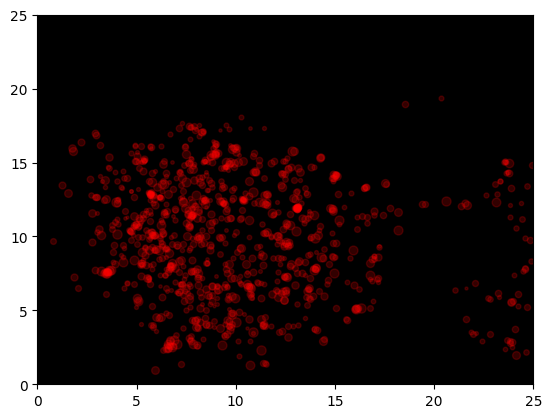

In [10]:
plt.figure()
ax = plt.axes()
ax.set_facecolor("black")

for i, histone in enumerate(histones):
    histone_first_pos = [histones[histone][0][0], histones[histone][0][1]]
    if histones_label[histone] in [0]:
        if histones_label[histone] == 0:
            c = 'red'
        if histones_label[histone] == 1:
            c = 'yellow'
        if histones_label[histone] == 2:
            c = 'blue'
        plt.scatter(histone_first_pos[0], histone_first_pos[1], c=c, s=histone_max_dist[histone]*100, alpha=0.2)
plt.xlim(0,25)
plt.ylim(0,25)

(0.0, 25.0)

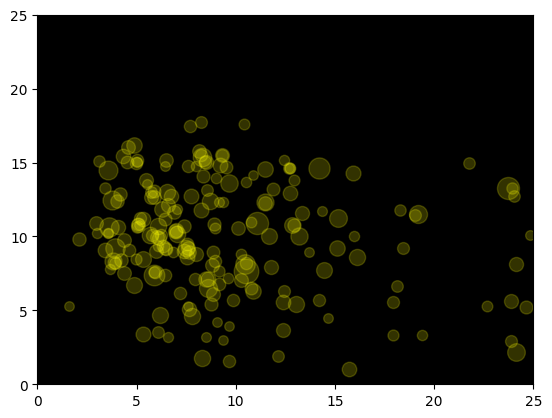

In [8]:
plt.figure()
ax = plt.axes()
ax.set_facecolor("black")

for i, histone in enumerate(histones):
    histone_first_pos = [histones[histone][0][0], histones[histone][0][1]]
    if histones_label[histone] in [1]:
        if histones_label[histone] == 0:
            c = 'red'
        if histones_label[histone] == 1:
            c = 'yellow'
        if histones_label[histone] == 2:
            c = 'blue'
        plt.scatter(histone_first_pos[0], histone_first_pos[1], c=c, s=histone_max_dist[histone]*100, alpha=0.2)
plt.xlim(0,25)
plt.ylim(0,25)

(0.0, 25.0)

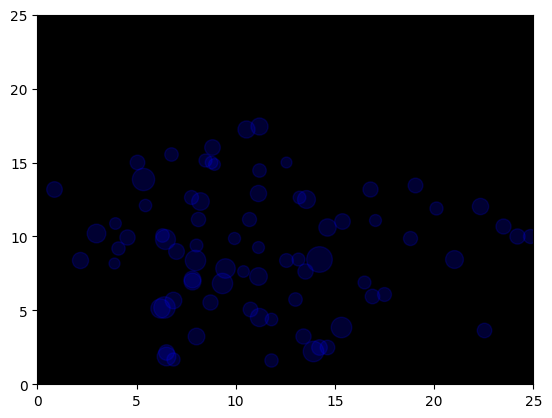

In [9]:
plt.figure()
ax = plt.axes()
ax.set_facecolor("black")

for i, histone in enumerate(histones):
    histone_first_pos = [histones[histone][0][0], histones[histone][0][1]]
    if histones_label[histone] in [2]:
        if histones_label[histone] == 0:
            c = 'red'
        if histones_label[histone] == 1:
            c = 'yellow'
        if histones_label[histone] == 2:
            c = 'blue'
        plt.scatter(histone_first_pos[0], histone_first_pos[1], c=c, s=histone_max_dist[histone]*100, alpha=0.2)
plt.xlim(0,25)
plt.ylim(0,25)